<a href="https://colab.research.google.com/github/slowings/Phase_4_Final_Project/blob/main/Phase_4_Final_Project_ModelAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Statements
import os, shutil
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import scipy
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

In [2]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'sample_data']


In [3]:
# Set path to xrays
drive_path = '/gdrive/MyDrive/Data/archive.zip'


In [4]:
# Navigate to xrays
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'archive.zip', 'sample_data']


In [5]:
# Unzip images
!unzip -q 'archive.zip'

### Check distribution
Now that we've confirmed the file path and unzipped our data, let's take a moment to create our paths to our data, and then double check the distribution of 'normal' vs. 'pneumonia' xrays in the train, test, and val directories to ensure all our files loaded properly

In [6]:
# Define paths to train, test and val sets
train_folder = '/content/chest_xray/train'
train_pneu = '/content/chest_xray/train/PNEUMONIA'
train_norm = '/content/chest_xray/train/NORMAL'

test_folder = '/content/chest_xray/test'
test_pneu = '/content/chest_xray/test/PNEUMONIA'
test_norm = '/content/chest_xray/test/NORMAL'

val_folder = '/content/chest_xray/val'
val_pneu = '/content/chest_xray/val/PNEUMONIA'
val_norm = '/content/chest_xray/val/NORMAL'

# Print distribution
print('Train PNEUMONIA= ', len(os.listdir(train_pneu)))
print('Train NORMAL= ', len(os.listdir(train_norm)))

print('Test PNEUMONIA= ', len(os.listdir(test_pneu)))
print('Test NORMAL= ', len(os.listdir(test_norm)))

print('Val PNEUMONIA= ', len(os.listdir(val_pneu)))
print('Val NORMAL= ', len(os.listdir(val_norm)))


Train PNEUMONIA=  3875
Train NORMAL=  1341
Test PNEUMONIA=  390
Test NORMAL=  234
Val PNEUMONIA=  8
Val NORMAL=  8


In [ ]:
# Confirm varied image size by taking samples and printing shape
image_path = '/content/chest_xray/train/PNEUMONIA'

# Get the list of images in the dataset
image_files = os.listdir(image_path)

# Get the first image file
first_image_file = image_files[0]

# Load the image using OpenCV
image = cv2.imread(os.path.join(image_path, first_image_file))

# Get the dimensions of the image
height, width, channels = image.shape

print("Image Width:", width)
print("Image Height:", height)
print("Number of Channels:", channels)

Image Width: 668
Image Height: 375
Number of Channels: 3


## Data Preprocessing

### Generate Augmented Tensors
Below we'll create our dataframes of our augmented, rescaled and resized images, begining with defining the architecture of our augemnted ImageGenerator, which, just as before,  we'll use to read in our data in batches, normalizing pixel output, scaling images, converting to greyscale, and setting to the binary class mode for our target variable, y.  We'll be augmenting our normal cases by using the following settings:
Technique	Setting
Rotation	45
Vertical Shift	0.2
Horizontal Shift	0.15
Shear	16
Crop and Pad	0.25

In [16]:
# Create Image Data Generator for Train Set to augment normal cases
image_gen = ImageDataGenerator(
        rotation_range = 45,
        width_shift_range=0.15,
        height_shift_range=0.2,
        rescale = 1./255)

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = image_gen.flow_from_directory(
        train_folder,
        target_size=(224, 224), batch_size=5216,
        class_mode='binary',
        color_mode = 'grayscale',
        shuffle=False,
        seed=18
        )

# get all the data in the "test" directory (624 images), rescale and reshape them
test_generator = test_data_gen.flow_from_directory(
        test_folder,
        target_size=(224, 224), batch_size = 624,
        class_mode='binary',
        color_mode = 'grayscale',
        shuffle=False,
        seed=18)

# get all the data in the "split/validation" directory (16 images), rescale and reshape them
val_generator = val_data_gen.flow_from_directory(
        val_folder,
        target_size=(224, 224), batch_size = 16,
        class_mode='binary',
        color_mode = 'grayscale',
        shuffle=False,
        seed=18)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [17]:
# Batch feed and join images/labels to create data sets
X_train_aug, y_train_aug = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [ ]:
# Explore dataset again to ensure all files are there and in desired shape
print ("Train_images shape: " + str(X_train.shape))
print ("Train_labels shape: " + str(y_train.shape))
print ("Test_images shape: " + str(X_test.shape))
print ("Test_labels shape: " + str(y_test.shape))
print ("Val_images shape: " + str(X_val.shape))
print ("Val_labels shape: " + str(y_val.shape))

Train_images shape: (5216, 224, 224, 1)
Train_labels shape: (5216,)
Test_images shape: (624, 224, 224, 1)
Test_labels shape: (624,)
Val_images shape: (16, 224, 224, 1)
Val_labels shape: (16,)


## Image Augmentation Using PNet: 6th model

The architecture of PNet is straightforward, consisting of only five convolution blocks, each followed by a max‐pooling layer. This small architecture allows PNet to be 25 times as efficient as AlexNet and about 50 times as efficient as visual geometric group (VGG) detection task with an accuracy of 92.79% and an F1 score of 0.93. Even though PNet has a smaller number of parameters, it outperforms both the AlexNet and VGG 16 in the pneumonia

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9086991/

"A very small
receptive field: 3×3 (which is the smallest size to capture the
notion of left/right, up/down, center) was also taken into
consideration to extract deep feature of CXRs.  PNet-5 contains
five convolutional layers and uses 3×3 convolutional filters
between all layers to convey relative information from low
level to high level. After feature extraction, the learned
convolutional feature weights are flattened and sent to two
fully-connected layers for label prediction. Spatial pooling is
carried out by five max-pooling layers, which follow each of
the convolutional layers. Max-pooling is performed over a 2 ×
2 pixel window to enhance the generalization ability of the
network."

https://www.researchgate.net/profile/Zhongliang-Li-4/publication/338800181_PNet_An_Efficient_Network_for_Pneumonia_Detection/links/5ea599ee299bf11256104d2e/PNet-An-Efficient-Network-for-Pneumonia-Detection.pdf

In [18]:
model = models.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1, padding = 'same',
                 activation = 'relu', input_shape = (224, 224, 1)))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(1 , activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [19]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


In [20]:
history = model.fit(X_train_aug,
                       y_train_aug,
                       epochs=20,
                       batch_size=20,
                       callbacks= [callbacks],
                       validation_data=(X_val, y_val))

Epoch 1/20
261/261 [==============================] - 16s 11ms/step - loss: 0.4429 - acc: 0.7920 - val_loss: 0.5524 - val_acc: 0.8125
Epoch 2/20
 13/261 [>.............................] - ETA: 2s - loss: 0.3334 - acc: 0.8462

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/261 [==============================] - 2s 9ms/step - loss: 0.3159 - acc: 0.8639 - val_loss: 0.5672 - val_acc: 0.8125
Epoch 3/20
261/261 [==============================] - 2s 9ms/step - loss: 0.2626 - acc: 0.8869 - val_loss: 0.8944 - val_acc: 0.6875
Epoch 4/20
261/261 [==============================] - 2s 9ms/step - loss: 0.2251 - acc: 0.9089 - val_loss: 0.5695 - val_acc: 0.6250
Epoch 5/20
261/261 [==============================] - 2s 9ms/step - loss: 0.1831 - acc: 0.9296 - val_loss: 0.9836 - val_acc: 0.6875


In [63]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [23]:
def visualize_CNN_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """
  # Plot Train and Val Loss
  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['train_loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  # Plot Train and Val Accuracy
  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['train_accuracy', 'val_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()



  # Test Set Confusion Matrix
  y_hat_test = model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test > thresh).astype(int)
  y_true = y_test.astype(int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Test Confusion Matrix')
  plt.show()




  # Check final metrics
  train_loss, train_acc= results.model.evaluate(X_train_aug, y_train_aug)
  test_loss, test_acc= results.model.evaluate(X_test, y_test)

  print('------------------------------')


  print(f'Train Loss: {train_loss}')
  print(f'Train Acc: {train_acc}')

  print('------------------------------')

  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')


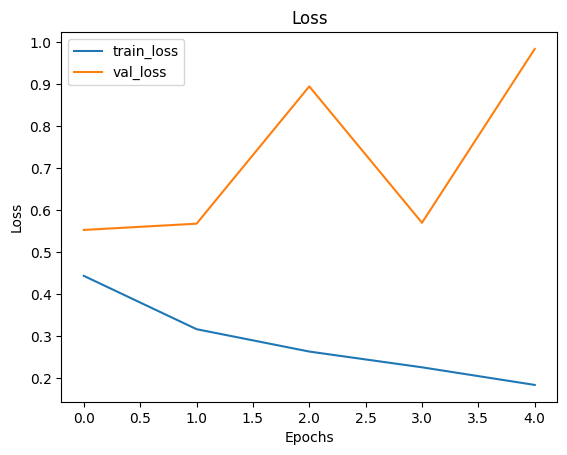

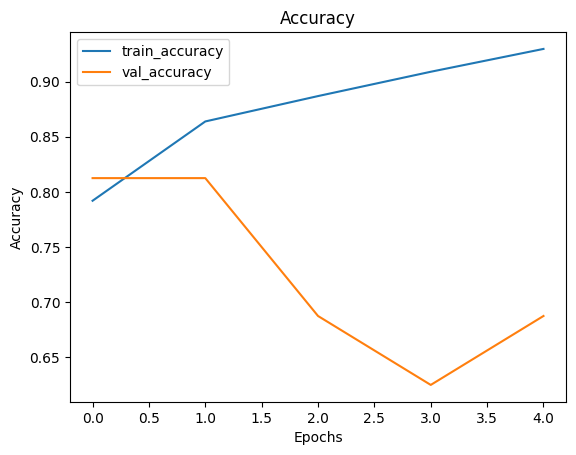

20/20 [==============================] - 0s 5ms/step


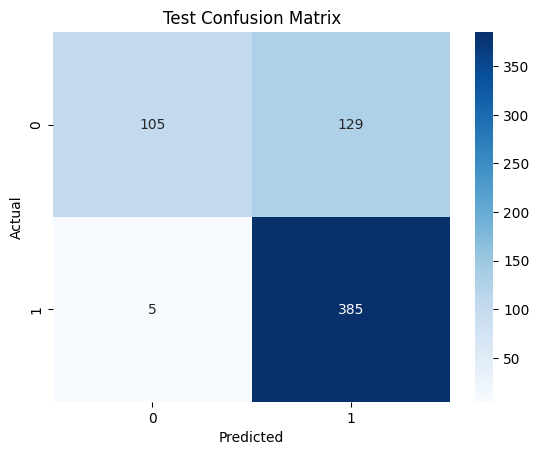

20/20 [==============================] - 0s 6ms/step - loss: 0.7981 - acc: 0.7853
------------------------------
Train Loss: 0.12286760658025742
Train Acc: 0.9541794657707214
------------------------------
Test Loss: 0.7980787754058838
Test Acc: 0.7852563858032227


In [24]:
visualize_CNN_results(history)

# Transfer Learning


"A novel approach based on a weighted classifier is introduced, which combines the weighted predictions from the state-of-the-art deep learning models such as ResNet18, Xception, InceptionV3, DenseNet121, and MobileNetV3 in an optimal way. This approach is a supervised learning approach in which the network predicts the result based on the quality of the dataset used. Transfer learning is used to fine-tune the deep learning models to obtain higher training and validation accuracy. Partial data augmentation techniques are employed to increase the training dataset in a balanced way."

"The main contribution is a weighted classifier that integrates five deep learning models. The weights for each model are based on each model’s performance on the testing dataset."

"The main disadvantage with deeper CNNs is vanishing gradients, which can be solved by using residual networks introduced in the following section."

"Due to the lack of a sufficient dataset, training a deep learning based model for medical diagnosis related problems is computationally expensive, and the results achieved are also not up to the mark. Hence, pre-trained deep learning models, which were previously trained on ImageNet [54] dataset, were used in this paper. Further, all these pre-trained models were fine-tuned for pneumonia classification. All the layers of the architectures used were trainable. Further details, related to fine-tuning, are discussed in Section 5.2.

"Each image had to be preprocessed according to the deep neural network used. There were two important steps involved: resizing and normalization. Different neural networks require images of different sizes according to their defined architecture. ResNet18, DenseNet121, and MobileNetV2 expect images of size 224 × 224, while InceptionV3 and Xception require images of size 229 × 229. All the images were also normalized according to the respective architectures."

"There were already enough images in the pneumonia case. Therefore, each image of only the normal (healthy) case was augmented twice. Finally, after augmentation, there were 3399 healthy chest X-ray images and 3623 pneumonia chest X-ray images."
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7345724/


Using DenseNet as our base, we'll try building a CNN on top of a pretrained model to see if we get better results.

In [57]:
# Create Image Data Generator for Train Set to augment normal cases
image_gen = ImageDataGenerator(
        rescale = 1./255)

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

# get all the data in the "train" directory (5216 images), rescale and reshape them
train_generator = image_gen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        batch_size= 5216,
        class_mode='binary',
        shuffle=False,
        seed=18)

# get all the data in the "test" directory (624 images), rescale and reshape them
test_generator = test_data_gen.flow_from_directory(
        test_folder,
        target_size=(224, 224),
        batch_size = 624,
        class_mode='binary',
        shuffle=False,
        seed=18)

# get all the data in the "split/validation" directory (16 images), rescale and reshape them
val_generator = val_data_gen.flow_from_directory(
        val_folder,
        target_size=(224, 224),
        batch_size = 16,
        class_mode='binary',
        shuffle=False,
        seed=18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [58]:
# Batch feed and join images/labels to create data sets
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [ ]:
print ("Train_images shape: " + str(X_train.shape))
print ("Train_labels shape: " + str(y_train.shape))
print ("Test_images shape: " + str(X_test.shape))
print ("Test_labels shape: " + str(y_test.shape))
print ("Val_images shape: " + str(X_val.shape))
print ("Val_labels shape: " + str(y_val.shape))

Train_images shape: (5216, 224, 224, 3)
Train_labels shape: (5216,)
Test_images shape: (624, 224, 224, 3)
Test_labels shape: (624,)
Val_images shape: (16, 224, 224, 3)
Val_labels shape: (16,)


In [59]:
base_model = DenseNet121(input_shape=(224, 224, 3),
                         include_top=False,
                         pooling='avg')


In [60]:
model = models.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1, padding = 'same',
                 activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(1 , activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [61]:
tl_model = models.Sequential()
tl_model.add(base_model)
tl_model.add(Flatten())
tl_model.add(Dense(128, activation='relu'))
tl_model.add(Dense(1, activation='sigmoid'))

In [62]:
# Check which layers can be frozen
for layer in tl_model.layers:
  print(layer.name, layer.trainable)

print(len(tl_model.trainable_weights))

densenet121 True
flatten_8 True
dense_26 True
dense_27 True
366


In [63]:
# Freeze the model
base_model.trainable = False

In [64]:
# Double check that it has been frozen
for layer in tl_model.layers:
  print(layer.name, layer.trainable)

print(len(tl_model.trainable_weights))

densenet121 False
flatten_8 True
dense_26 True
dense_27 True
4


In [65]:
tl_model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [70]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


In [71]:
results = tl_model.fit(X_train,
                   y_train,
                   epochs=20,
                   batch_size=32,
                   validation_split=.2,
                   callbacks=[callbacks])

Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.1147 - acc: 0.9571

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 8s 62ms/step - loss: 0.1147 - acc: 0.9571 - val_loss: 0.0335 - val_acc: 0.9895
Epoch 2/20
131/131 [==============================] - 6s 48ms/step - loss: 0.1053 - acc: 0.9566 - val_loss: 0.0924 - val_acc: 0.9626
Epoch 3/20
131/131 [==============================] - 6s 48ms/step - loss: 0.1029 - acc: 0.9590 - val_loss: 0.2328 - val_acc: 0.9033
Epoch 4/20
131/131 [==============================] - 7s 53ms/step - loss: 0.0882 - acc: 0.9657 - val_loss: 0.0107 - val_acc: 0.9971
Epoch 5/20
131/131 [==============================] - 6s 47ms/step - loss: 0.0809 - acc: 0.9700 - val_loss: 0.0294 - val_acc: 0.9914
Epoch 6/20
131/131 [==============================] - 6s 48ms/step - loss: 0.0831 - acc: 0.9693 - val_loss: 0.1333 - val_acc: 0.9416
Epoch 7/20
131/131 [==============================] - 6s 48ms/step - loss: 0.0778 - acc: 0.9698 - val_loss: 0.0353 - val_acc: 0.9904
Epoch 8/20
131/131 [==============================] - 6s 48ms/step - loss: 0.070

In [73]:
def visualize_CNN_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """
  # Plot Train and Val Loss
  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['train_loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  # Plot Train and Val Accuracy
  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['train_accuracy', 'val_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()



  # Test Set Confusion Matrix
  y_hat_test = model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test > thresh).astype(int)
  y_true = y_test.astype(int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Test Confusion Matrix')
  plt.show()

  # Check final metrics
  train_loss, train_acc= results.model.evaluate(X_train, y_train)
  test_loss, test_acc= results.model.evaluate(X_test, y_test)

  print('------------------------------')


  print(f'Train Loss: {train_loss}')
  print(f'Train Acc: {train_acc}')

  print('------------------------------')

  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')



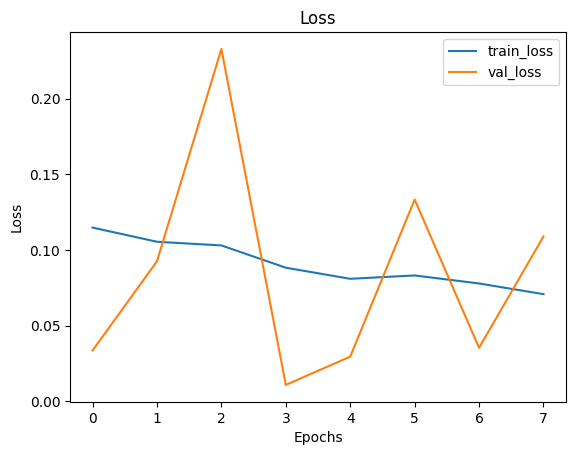

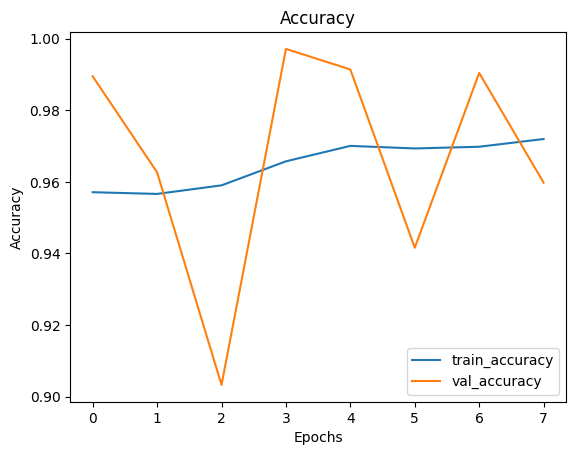

20/20 [==============================] - 0s 10ms/step


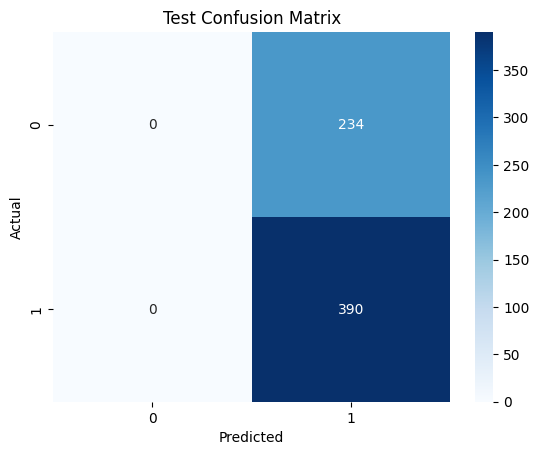

InternalError: ignored

In [74]:
visualize_CNN_results(results)

### Save Final Model

In [ ]:
# Save Model * as final model
final_cnn_path = '/content/drive/MyDrive/final_pre_trained_cnn.hd5'

model***.save(final_cnn_path)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    auc = roc_auc_score(labels, predictions)
    plt.figure(figsize=(8, 6))
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, 'g', label='AUC Score = %0.2f' % auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()
